# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 4s 28ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 19.0071 - energy_loss: 0.2774 - force_loss: 0.9365 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9397 - energy_loss: 0.2146 - force_loss: 0.9363 - 541ms/epoch - 68ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9244 - energy_loss: 0.2051 - force_loss: 0.9360 - 546ms/epoch - 68ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.9050 - energy_loss: 0.2049 - force_loss: 0.9350 - 545ms/epoch - 68ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.8051 - energy_loss: 0.2129 - force_loss: 0.9296 - 543ms/epoch - 68ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.5902 - energy_loss: 0.4061 - force_loss: 0.9092 - 547ms/epoch - 68ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.3205 - energy_loss: 0.5344 - force_loss: 0.8893 - 541ms/epoch - 68ms/step
Epoch 8/1500
8/8 - 1s - loss: 17.8161 - energy_loss: 0.6989 - force_loss: 0.8559 - 543ms/epoch - 68ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.3067 - energy_loss: 0.9194 - force_loss: 0.8194 - 549ms/epoch - 69ms/step
Epoch 10/1500
8/8 - 1s - loss: 16.7140 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.9669 - energy_loss: 1.0023 - force_loss: 0.2982 - 565ms/epoch - 71ms/step
Epoch 79/1500
8/8 - 1s - loss: 7.0135 - energy_loss: 0.9725 - force_loss: 0.3021 - 565ms/epoch - 71ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.6917 - energy_loss: 0.8793 - force_loss: 0.2906 - 559ms/epoch - 70ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.5677 - energy_loss: 0.8489 - force_loss: 0.2859 - 570ms/epoch - 71ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.5323 - energy_loss: 0.8228 - force_loss: 0.2855 - 557ms/epoch - 70ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.5095 - energy_loss: 0.8418 - force_loss: 0.2834 - 556ms/epoch - 69ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.5287 - energy_loss: 0.8516 - force_loss: 0.2839 - 561ms/epoch - 70ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.5888 - energy_loss: 0.8582 - force_loss: 0.2865 - 565ms/epoch - 71ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.5638 - energy_loss: 0.8372 - force_loss: 0.2863 - 573ms/epoch - 72ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.5563

8/8 - 1s - loss: 4.5623 - energy_loss: 0.7664 - force_loss: 0.1898 - 552ms/epoch - 69ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.5234 - energy_loss: 0.7384 - force_loss: 0.1892 - 568ms/epoch - 71ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.4893 - energy_loss: 0.7477 - force_loss: 0.1871 - 577ms/epoch - 72ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.5783 - energy_loss: 0.7085 - force_loss: 0.1935 - 547ms/epoch - 68ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.5283 - energy_loss: 0.6458 - force_loss: 0.1941 - 556ms/epoch - 69ms/step
Epoch 159/1500
8/8 - 1s - loss: 5.0519 - energy_loss: 0.7034 - force_loss: 0.2174 - 545ms/epoch - 68ms/step
Epoch 160/1500
8/8 - 1s - loss: 5.1015 - energy_loss: 0.7927 - force_loss: 0.2154 - 546ms/epoch - 68ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.8648 - energy_loss: 0.7396 - force_loss: 0.2063 - 551ms/epoch - 69ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.4522 - energy_loss: 0.6809 - force_loss: 0.1886 - 551ms/epoch - 69ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.4973 - en

Epoch 230/1500
8/8 - 1s - loss: 4.4195 - energy_loss: 0.9997 - force_loss: 0.1710 - 541ms/epoch - 68ms/step
Epoch 231/1500
8/8 - 1s - loss: 4.5918 - energy_loss: 1.0566 - force_loss: 0.1768 - 582ms/epoch - 73ms/step
Epoch 232/1500
8/8 - 1s - loss: 4.4640 - energy_loss: 1.0446 - force_loss: 0.1710 - 543ms/epoch - 68ms/step
Epoch 233/1500
8/8 - 1s - loss: 4.3416 - energy_loss: 0.9315 - force_loss: 0.1705 - 572ms/epoch - 71ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.8047 - energy_loss: 0.4973 - force_loss: 0.1654 - 571ms/epoch - 71ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.3854 - energy_loss: 0.2492 - force_loss: 0.1568 - 583ms/epoch - 73ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.3256 - energy_loss: 0.2630 - force_loss: 0.1531 - 547ms/epoch - 68ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.3778 - energy_loss: 0.3277 - force_loss: 0.1525 - 575ms/epoch - 72ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.2680 - energy_loss: 0.2883 - force_loss: 0.1490 - 545ms/epoch - 68ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.3900 - energy_loss: 0.5632 - force_loss: 0.1413 - 539ms/epoch - 67ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.3886 - energy_loss: 0.5204 - force_loss: 0.1434 - 535ms/epoch - 67ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.3651 - energy_loss: 0.4878 - force_loss: 0.1439 - 541ms/epoch - 68ms/step
Epoch 309/1500
8/8 - 1s - loss: 2.8487 - energy_loss: 0.1866 - force_loss: 0.1331 - 539ms/epoch - 67ms/step
Epoch 310/1500
8/8 - 1s - loss: 2.8804 - energy_loss: 0.2931 - force_loss: 0.1294 - 538ms/epoch - 67ms/step
Epoch 311/1500
8/8 - 1s - loss: 2.8316 - energy_loss: 0.2503 - force_loss: 0.1291 - 543ms/epoch - 68ms/step
Epoch 312/1500
8/8 - 1s - loss: 2.8386 - energy_loss: 0.2657 - force_loss: 0.1286 - 535ms/epoch - 67ms/step
Epoch 313/1500
8/8 - 1s - loss: 2.8153 - energy_loss: 0.2305 - force_loss: 0.1292 - 535ms/epoch - 67ms/step
Epoch 314/1500
8/8 - 1s - loss: 2.9068 - energy_loss: 0.2675 - force_loss: 0.1320 - 537ms/epoch - 67ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 3.7322 - energy_loss: 1.0801 - force_loss: 0.1326 - 543ms/epoch - 68ms/step
Epoch 383/1500
8/8 - 1s - loss: 3.0753 - energy_loss: 0.5009 - force_loss: 0.1287 - 540ms/epoch - 68ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.0352 - energy_loss: 0.5258 - force_loss: 0.1255 - 539ms/epoch - 67ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.0694 - energy_loss: 0.6666 - force_loss: 0.1201 - 555ms/epoch - 69ms/step
Epoch 386/1500
8/8 - 1s - loss: 3.0086 - energy_loss: 0.6121 - force_loss: 0.1198 - 552ms/epoch - 69ms/step
Epoch 387/1500
8/8 - 1s - loss: 2.9067 - energy_loss: 0.4694 - force_loss: 0.1219 - 546ms/epoch - 68ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.6205 - energy_loss: 0.2111 - force_loss: 0.1205 - 541ms/epoch - 68ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.8783 - energy_loss: 0.4632 - force_loss: 0.1208 - 644ms/epoch - 81ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.8729 - energy_loss: 0.4304 - force_loss: 0.1221 - 648ms/epoch - 81ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.7799 - energy_loss: 0.4776 - force_loss: 0.1151 - 582ms/epoch - 73ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.7352 - energy_loss: 0.4841 - force_loss: 0.1126 - 554ms/epoch - 69ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.8919 - energy_loss: 0.5055 - force_loss: 0.1193 - 585ms/epoch - 73ms/step
Epoch 461/1500
8/8 - 1s - loss: 3.0818 - energy_loss: 0.4952 - force_loss: 0.1293 - 582ms/epoch - 73ms/step
Epoch 462/1500
8/8 - 1s - loss: 3.0140 - energy_loss: 0.5213 - force_loss: 0.1246 - 578ms/epoch - 72ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.7733 - energy_loss: 0.4999 - force_loss: 0.1137 - 547ms/epoch - 68ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.6241 - energy_loss: 0.4337 - force_loss: 0.1095 - 544ms/epoch - 68ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.6192 - energy_loss: 0.4274 - force_loss: 0.1096 - 552ms/epoch - 69ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.6871 - energy_loss: 0.4428 - force_loss: 0.1122 - 549ms/epoch - 69ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.6146 - energy_loss: 0.4334 - force_loss: 0.1091 - 684ms/epoch - 85ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.8958 - energy_loss: 0.4993 - force_loss: 0.1198 - 619ms/epoch - 77ms/step
Epoch 536/1500
8/8 - 1s - loss: 3.1186 - energy_loss: 0.5499 - force_loss: 0.1284 - 585ms/epoch - 73ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.9143 - energy_loss: 0.5578 - force_loss: 0.1178 - 686ms/epoch - 86ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.6143 - energy_loss: 0.4517 - force_loss: 0.1081 - 710ms/epoch - 89ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.6722 - energy_loss: 0.4748 - force_loss: 0.1099 - 701ms/epoch - 88ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.7722 - energy_loss: 0.5184 - force_loss: 0.1127 - 785ms/epoch - 98ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.6214 - energy_loss: 0.4774 - force_loss: 0.1072 - 794ms/epoch - 99ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.7821 - energy_loss: 0.4037 - force_loss: 0.1189 - 603ms/epoch - 75ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.7932 - energy_loss: 0.4610 - force_loss: 0.1166 - 624ms/epoch - 78ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.6552 - energy_loss: 0.4373 - force_loss: 0.1109 - 585ms/epoch - 73ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.3976 - energy_loss: 0.3232 - force_loss: 0.1037 - 595ms/epoch - 74ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.2188 - energy_loss: 0.2149 - force_loss: 0.1002 - 636ms/epoch - 79ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.2034 - energy_loss: 0.2319 - force_loss: 0.0986 - 697ms/epoch - 87ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.4120 - energy_loss: 0.4478 - force_loss: 0.0982 - 714ms/epoch - 89ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.4415 - energy_loss: 0.3428 - force_loss: 0.1049 - 734ms/epoch - 92ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.3457 - energy_loss: 0.3239 - force_loss: 0.1011 - 748ms/epoch - 93ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.4681 - energy_loss: 0.4674 - force_loss: 0.1000 - 589ms/epoch - 74ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.2652 - energy_loss: 0.4148 - force_loss: 0.0925 - 705ms/epoch - 88ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.2570 - energy_loss: 0.4147 - force_loss: 0.0921 - 730ms/epoch - 91ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.3835 - energy_loss: 0.3971 - force_loss: 0.0993 - 696ms/epoch - 87ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.5634 - energy_loss: 0.4410 - force_loss: 0.1061 - 782ms/epoch - 98ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.4055 - energy_loss: 0.4138 - force_loss: 0.0996 - 764ms/epoch - 95ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.4119 - energy_loss: 0.4227 - force_loss: 0.0995 - 707ms/epoch - 88ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.4804 - energy_loss: 0.4100 - force_loss: 0.1035 - 581ms/epoch - 73ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.5284 - energy_loss: 0.4271 - force_loss: 0.1051 - 561ms/epoch - 70ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.4115 - energy_loss: 0.4111 - force_loss: 0.1000 - 552ms/epoch - 69ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.5377 - energy_loss: 0.3599 - force_loss: 0.1089 - 574ms/epoch - 72ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.7213 - energy_loss: 0.7014 - force_loss: 0.1010 - 549ms/epoch - 69ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.3597 - energy_loss: 0.2863 - force_loss: 0.1037 - 553ms/epoch - 69ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.4294 - energy_loss: 0.4342 - force_loss: 0.0998 - 588ms/epoch - 73ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.3021 - energy_loss: 0.3762 - force_loss: 0.0963 - 554ms/epoch - 69ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.3795 - energy_loss: 0.4652 - force_loss: 0.0957 - 556ms/epoch - 69ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.3320 - energy_loss: 0.4004 - force_loss: 0.0966 - 556ms/epoch - 69ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.2313 - energy_loss: 0.4310 - force_loss: 0.0900 - 550ms/epoch - 69ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.1647 - energy_loss: 0.3766 - force_loss: 0.0894 - 560ms/epoch - 70ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.4714 - energy_loss: 0.6817 - force_loss: 0.0895 - 544ms/epoch - 68ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.1321 - energy_loss: 0.2827 - force_loss: 0.0925 - 535ms/epoch - 67ms/step
Epoch 840/1500
8/8 - 1s - loss: 1.9844 - energy_loss: 0.2222 - force_loss: 0.0881 - 537ms/epoch - 67ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.2610 - energy_loss: 0.4607 - force_loss: 0.0900 - 546ms/epoch - 68ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.0411 - energy_loss: 0.1828 - force_loss: 0.0929 - 538ms/epoch - 67ms/step
Epoch 843/1500
8/8 - 1s - loss: 1.9550 - energy_loss: 0.1807 - force_loss: 0.0887 - 544ms/epoch - 68ms/step
Epoch 844/1500
8/8 - 1s - loss: 1.8631 - energy_loss: 0.1502 - force_loss: 0.0856 - 541ms/epoch - 68ms/step
Epoch 845/1500
8/8 - 1s - loss: 1.8767 - energy_loss: 0.1899 - force_loss: 0.0843 - 554ms/epoch - 69ms/step
Epoch 846/1500
8/8 - 1s - loss: 1.8511 - energy_loss: 0.1896 - force_loss: 0.0831 - 552ms/epoch - 69ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.0806 - energy_loss: 0.3527 - force_loss: 0.0864 - 558ms/epoch - 70ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.0974 - energy_loss: 0.3711 - force_loss: 0.0863 - 641ms/epoch - 80ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.1308 - energy_loss: 0.3573 - force_loss: 0.0887 - 694ms/epoch - 87ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.0917 - energy_loss: 0.3504 - force_loss: 0.0871 - 670ms/epoch - 84ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.1545 - energy_loss: 0.3520 - force_loss: 0.0901 - 650ms/epoch - 81ms/step
Epoch 919/1500
8/8 - 1s - loss: 1.9414 - energy_loss: 0.2017 - force_loss: 0.0870 - 605ms/epoch - 76ms/step
Epoch 920/1500
8/8 - 1s - loss: 1.8576 - energy_loss: 0.1400 - force_loss: 0.0859 - 648ms/epoch - 81ms/step
Epoch 921/1500
8/8 - 1s - loss: 1.9029 - energy_loss: 0.1943 - force_loss: 0.0854 - 632ms/epoch - 79ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.1651 - energy_loss: 0.3609 - force_loss: 0.0902 - 670ms/epoch - 84ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.3043 - energy_loss: 0.5506 - force_loss: 0.0877 - 548ms/epoch - 69ms/step
Epoch 991/1500
8/8 - 1s - loss: 1.8721 - energy_loss: 0.1658 - force_loss: 0.0853 - 557ms/epoch - 70ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.7988 - energy_loss: 0.1898 - force_loss: 0.0804 - 573ms/epoch - 72ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.7801 - energy_loss: 0.1788 - force_loss: 0.0801 - 633ms/epoch - 79ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.9679 - energy_loss: 0.3562 - force_loss: 0.0806 - 678ms/epoch - 85ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.8639 - energy_loss: 0.2206 - force_loss: 0.0822 - 655ms/epoch - 82ms/step
Epoch 996/1500
8/8 - 1s - loss: 2.0302 - energy_loss: 0.3689 - force_loss: 0.0831 - 655ms/epoch - 82ms/step
Epoch 997/1500
8/8 - 1s - loss: 2.0521 - energy_loss: 0.3220 - force_loss: 0.0865 - 664ms/epoch - 83ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.3625 - energy_loss: 0.6297 - force_loss: 0.0866 - 599ms/epoch - 75ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 2.2606 - energy_loss: 0.1851 - force_loss: 0.1038 - 733ms/epoch - 92ms/step
Epoch 1067/1500
8/8 - 1s - loss: 2.0247 - energy_loss: 0.3491 - force_loss: 0.0838 - 675ms/epoch - 84ms/step
Epoch 1068/1500
8/8 - 1s - loss: 2.0790 - energy_loss: 0.2885 - force_loss: 0.0895 - 716ms/epoch - 89ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.4165 - energy_loss: 0.4465 - force_loss: 0.0985 - 582ms/epoch - 73ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.0147 - energy_loss: 0.3306 - force_loss: 0.0842 - 643ms/epoch - 80ms/step
Epoch 1071/1500
8/8 - 1s - loss: 2.1370 - energy_loss: 0.3956 - force_loss: 0.0871 - 674ms/epoch - 84ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.9220 - energy_loss: 0.3266 - force_loss: 0.0798 - 615ms/epoch - 77ms/step
Epoch 1073/1500
8/8 - 1s - loss: 2.0082 - energy_loss: 0.3706 - force_loss: 0.0819 - 588ms/epoch - 73ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.7715 - energy_loss: 0.1445 - force_loss: 0.0813 - 568ms/epoch - 71ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 2.6499 - energy_loss: 1.1277 - force_loss: 0.0761 - 535ms/epoch - 67ms/step
Epoch 1143/1500
8/8 - 1s - loss: 2.1668 - energy_loss: 0.6507 - force_loss: 0.0758 - 540ms/epoch - 68ms/step
Epoch 1144/1500
8/8 - 1s - loss: 2.1237 - energy_loss: 0.5447 - force_loss: 0.0789 - 547ms/epoch - 68ms/step
Epoch 1145/1500
8/8 - 1s - loss: 2.2199 - energy_loss: 0.4789 - force_loss: 0.0871 - 547ms/epoch - 68ms/step
Epoch 1146/1500
8/8 - 1s - loss: 2.2412 - energy_loss: 0.3587 - force_loss: 0.0941 - 542ms/epoch - 68ms/step
Epoch 1147/1500
8/8 - 1s - loss: 2.2061 - energy_loss: 0.3963 - force_loss: 0.0905 - 541ms/epoch - 68ms/step
Epoch 1148/1500
8/8 - 1s - loss: 2.0105 - energy_loss: 0.2867 - force_loss: 0.0862 - 539ms/epoch - 67ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.7783 - energy_loss: 0.1746 - force_loss: 0.0802 - 537ms/epoch - 67ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.7907 - energy_loss: 0.2858 - force_loss: 0.0752 - 535ms/epoch - 67ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.9383 - energy_loss: 0.2705 - force_loss: 0.0834 - 546ms/epoch - 68ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.7639 - energy_loss: 0.1469 - force_loss: 0.0808 - 565ms/epoch - 71ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.7703 - energy_loss: 0.3385 - force_loss: 0.0716 - 560ms/epoch - 70ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.8897 - energy_loss: 0.3071 - force_loss: 0.0791 - 609ms/epoch - 76ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.9729 - energy_loss: 0.2936 - force_loss: 0.0840 - 591ms/epoch - 74ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.8903 - energy_loss: 0.3595 - force_loss: 0.0765 - 570ms/epoch - 71ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.9731 - energy_loss: 0.3438 - force_loss: 0.0815 - 575ms/epoch - 72ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.8907 - energy_loss: 0.3155 - force_loss: 0.0788 - 571ms/epoch - 71ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.8971 - energy_loss: 0.3534 - force_loss: 0.0772 - 550ms/epoch - 69ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.7201 - energy_loss: 0.3127 - force_loss: 0.0704 - 535ms/epoch - 67ms/step
Epoch 1295/1500
8/8 - 1s - loss: 2.0822 - energy_loss: 0.6238 - force_loss: 0.0729 - 543ms/epoch - 68ms/step
Epoch 1296/1500
8/8 - 1s - loss: 2.0448 - energy_loss: 0.5463 - force_loss: 0.0749 - 534ms/epoch - 67ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.7988 - energy_loss: 0.3019 - force_loss: 0.0748 - 537ms/epoch - 67ms/step
Epoch 1298/1500
8/8 - 1s - loss: 2.1179 - energy_loss: 0.5893 - force_loss: 0.0764 - 546ms/epoch - 68ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.7193 - energy_loss: 0.1679 - force_loss: 0.0776 - 544ms/epoch - 68ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.6151 - energy_loss: 0.1446 - force_loss: 0.0735 - 538ms/epoch - 67ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.5969 - energy_loss: 0.1695 - force_loss: 0.0714 - 539ms/epoch - 67ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.5035 - energy_loss: 0.1488 - force_loss: 0.0677 - 551ms/epoch - 69ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.8043 - energy_loss: 0.3088 - force_loss: 0.0748 - 549ms/epoch - 69ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.7380 - energy_loss: 0.3149 - force_loss: 0.0712 - 551ms/epoch - 69ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.7410 - energy_loss: 0.3141 - force_loss: 0.0713 - 539ms/epoch - 67ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.7700 - energy_loss: 0.3008 - force_loss: 0.0735 - 548ms/epoch - 69ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.7571 - energy_loss: 0.3074 - force_loss: 0.0725 - 557ms/epoch - 70ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.8678 - energy_loss: 0.2985 - force_loss: 0.0785 - 548ms/epoch - 69ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.9484 - energy_loss: 0.2904 - force_loss: 0.0829 - 594ms/epoch - 74ms/step
Epoch 1377/1500
8/8 - 1s - loss: 2.0384 - energy_loss: 0.3520 - force_loss: 0.0843 - 595ms/epoch - 74ms/step
Epoch 1378/1500
8/8 - 1s - loss: 2.0271 - energy_loss: 0.2958 - force_loss: 0.0866 - 577ms/epoch - 72ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.8355 - energy_loss: 0.2932 - force_loss: 0.0771 - 550ms/epoch - 69ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.8860 - energy_loss: 0.3087 - force_loss: 0.0789 - 541ms/epoch - 68ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.8637 - energy_loss: 0.3118 - force_loss: 0.0776 - 537ms/epoch - 67ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8258 - energy_loss: 0.3040 - force_loss: 0.0761 - 538ms/epoch - 67ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.8220 - energy_loss: 0.3001 - force_loss: 0.0761 - 540ms/epoch - 68ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.7628 - energy_loss: 0.2884 - force_loss: 0.0737 - 539ms/epoch - 67ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7528 - energy_loss: 0.3054 - force_loss: 0.0724 - 538ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.7530 - energy_loss: 0.3041 - force_loss: 0.0724 - 540ms/epoch - 67ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.7417 - energy_loss: 0.3005 - force_loss: 0.0721 - 539ms/epoch - 67ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

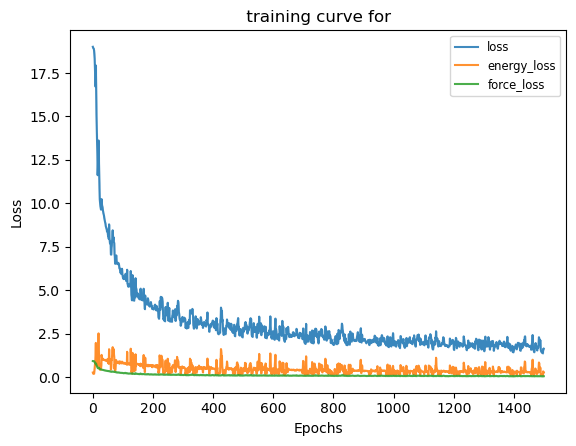

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices", "range_attributes"],  # and "range_images" if periodic.
    update_from_last_input_skip=2    
)

In [19]:
dyn_model(dataset[0:510])[0]

skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
s

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17470.3203123]),
 'forces': array([[-2.7518644e+00,  2.7498744e+00, -9.2358643e-01],
        [-8.4203333e-01, -9.4451630e-01,  2.0859225e+00],
        [ 2.9836142e+00, -2.1879721e+00, -1.0548961e-01],
        [-4.5552585e-01,  1.6974785e+00, -4.8874527e-02],
        [ 1.6305944e-01,  1.8179868e+00,  8.3115447e-01],
        [-3.9680526e-01,  1.9457054e-01, -1.1672591e-01],
        [ 3.0934474e-01,  5.7512707e-01, -2.1917353e+00],
        [-3.4679353e-01, -1.2783993e+00,  3.4143478e-03],
        [ 5.6010556e-01,  3.8464410e+00,  2.0235260e+00],
        [-7.5351959e-01,  2.1719861e+00,  8.2533115e-01],
        [ 1.2456856e+00, -1.3152759e+00,  4.5039603e-01],
        [ 3.7256095e-01, -3.7890761e+00, -1.9470389e+00],
        [ 1.8002840e+00, -8.1653410e-01, -7.0052737e-01],
        [-2.3406461e-01, -5.4569238e-01,  3.3227158e-01],
        [ 1.1665554e+00, -1.8289341e+00,  1.3048434e+00],
        [ 5.4603279e-02,  3.2169652e-01, -8.5107899e-01],
        [-1.1284554e+00,  

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

updates
skipping
{'energy': array(-17470.3203126), 'forces': array([[-2.75186419e+00,  2.74987364e+00, -9.23585892e-01],
       [-8.42034221e-01, -9.44516540e-01,  2.08592439e+00],
       [ 2.98361444e+00, -2.18797231e+00, -1.05489701e-01],
       [-4.55525607e-01,  1.69747841e+00, -4.88741994e-02],
       [ 1.63059622e-01,  1.81798673e+00,  8.31154764e-01],
       [-3.96806359e-01,  1.94570363e-01, -1.16725326e-01],
       [ 3.09345037e-01,  5.75126648e-01, -2.19173598e+00],
       [-3.46793652e-01, -1.27839947e+00,  3.41457129e-03],
       [ 5.60105681e-01,  3.84644294e+00,  2.02352715e+00],
       [-7.53519177e-01,  2.17198706e+00,  8.25330317e-01],
       [ 1.24568534e+00, -1.31527567e+00,  4.50396091e-01],
       [ 3.72561067e-01, -3.78907609e+00, -1.94703960e+00],
       [ 1.80028486e+00, -8.16535234e-01, -7.00527906e-01],
       [-2.34064758e-01, -5.45692205e-01,  3.32271576e-01],
       [ 1.16655540e+00, -1.82893419e+00,  1.30484390e+00],
       [ 5.46033531e-02,  3.21696579e-0

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.920eV  Ekin = 0.037eV (T=288K)  Etot = -831.883eV
updates
skipping


updates
skipping


updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.934eV  Ekin = 0.051eV (T=395K)  Etot = -831.883eV
updates
skipping
updates
skipping
updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.934eV  Ekin = 0.051eV (T=393K)  Etot = -831.884eV
updates
skipping
updates
skipping
updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.929eV  Ekin = 0.046eV (T=353K)  Etot = -831.884eV
updates
skipping
updates
skipping
updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.929eV  Ekin = 0.051eV (T=398K)  Etot = -831.878eV
updates
skipping
updates
skipping
updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.938eV  Ekin = 0.061eV (T=472K)  Etot = -831.877eV
updates
skipping
updates
skipping
updates
skipping
updates
skipping
updates
skipping
Energy per atom: Epot = -831.934eV  Ekin = 0.054eV (T=421K)  Etot = -831.880eV
updates
skipping
updates
skipping
updates
skipping

In [30]:
calc.model_predictor._last_input

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 1.59570254, -1.38259717, -0.14002491],
       [ 0.88463712,  1.11567184, -1.28089138],
       [ 2.3945162 , -0.78823874, -1.19701463],
       [ 2.02549084,  0.44480077, -1.75558647],
       [-3.22806054,  1.83948373,  0.26655673],
       [ 0.58197138, -0.65005196,  0.50202676],
       [ 0.25232944,  0.63606522, -0.15038494],
       [-0.92355774, -0.49673773,  2.5141174 ],
       [-2.06743391,  0.90229327, -1.5932501 ],
       [ 0.53790422, -2.18753527,  2.28393352],
       [-0.04639704, -1.0254104 ,  1.83436521],
       [-1.98976643,  1.31236136, -0.48091986],
       [-0.88360799,  1.24515785,  0.38170632],
       [ 0.08994637, -2.29110841,  3.17952984],
       [ 1.88594532, -2.35878953,  0.22588483],
       [ 0.48378957,  1.95105234, -1.87837531],
       [ 3.29662624, -1.37688249, -1.5662076 ],
       [ 2.33381613,  0.96772426, -2.69334497],
       [-4.02087